In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from astropy.io import fits
from scipy import interpolate
from rhanalyze.satlas import satlas

In [2]:
scan_dir = '/mnt/data1/Data/pid_1_118/Aligned/'

nscan   = 1
scanIDs = ['1709', '1738', '1807', '1836', '1905', '1933', '2002', '2032']
scanID  = 'scan' + scanIDs[nscan]

arm6302_file = scan_dir + 'arm6302_' + scanID + '_6302coalinged.fits'
arm8542_file = scan_dir + 'arm8542_' + scanID + '_6302coalinged.fits'

In [3]:
hdul = fits.open(arm6302_file)
hdul.info()
arm6302_data = hdul[0].data
hdul.close()

hdul = fits.open(arm8542_file)
hdul.info()
arm8542_data = hdul[0].data
hdul.close()

Filename: /mnt/data1/Data/pid_1_118/Aligned/arm6302_scan1836_6302coalinged.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (4, 150, 490, 2555)   float32   
Filename: /mnt/data1/Data/pid_1_118/Aligned/arm8542_scan1836_6302coalinged.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (4, 500, 490, 2555)   float32   


In [4]:
MILLI          = 1.0E-3
NM_TO_ANGSTROM = 10.0

In [5]:
wave6302_file = scan_dir + 'wavelength_scan1709_6302_v1.txt'
wave8542_file = scan_dir + 'wavelength_scan1709_8542_v1.txt'

wave6302 = np.loadtxt(wave6302_file, dtype="float") / NM_TO_ANGSTROM
wave8542 = np.loadtxt(wave8542_file, dtype="float") / NM_TO_ANGSTROM

In [6]:
NxCaII_0 = 277
NxCaII_1 = 1945

NyCaII_0 = 3
NyCaII_1 = 490

<Figure size 1400x700 with 0 Axes>

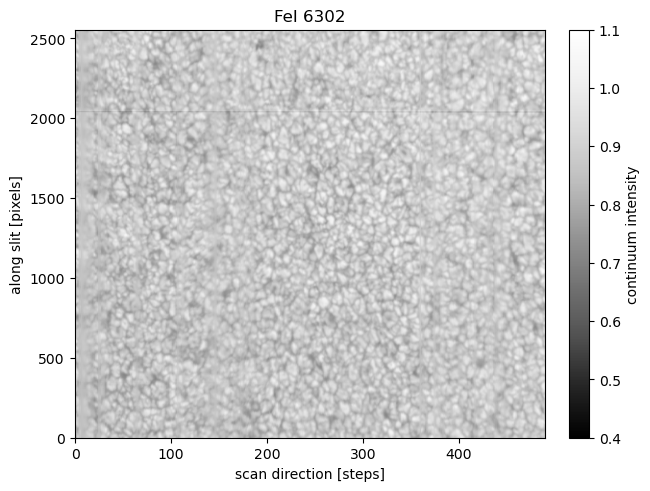

In [7]:
plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

cmap_grey = plt.cm.Greys.reversed()

im = axs.imshow(arm6302_data[:, :, 0, 0], cmap=cmap_grey, \
                vmin=0.4, vmax=1.1, \
                aspect='auto', origin='lower')
axs.set(xlabel = 'scan direction [steps]', ylabel='along slit [pixels]', title='FeI 6302')

plt.colorbar(im, label='continuum intensity')
plt.show()

In [8]:
(Npix, Nscan, Nwave, Nstokes) = np.shape(arm6302_data)
print(Npix, Nscan, Nwave, Nstokes)

2555 490 150 4


In [9]:
def monotonic_increasing(x):
    dx = np.diff(x)
    return np.all(dx > 0)

def table_invert(table, values, mode=None):
    
    if np.ndim(table) == 0:
        print("Table cannot be a scalar!")
        return table
        
    t_array = np.array(table)
    
    if np.size(t_array) <= 1:
        print("Table cannot have one element!")
        return t_array
    
    if monotonic_increasing(t_array) == False:
        print("Table has to be monotonically increasing!")
        return None
    
    if np.ndim(values) == 0:
        v_array = np.array([values])
    else:  
        v_array = np.array(values)
    
    lookup = []
    for v in v_array:
        if v <= t_array[0]:
            lookup.append({"index": 0, "value": t_array[0], "eff_index": 0})
        elif v >= t_array[-1]:
            lookup.append({"index": len(t_array)-1, "value": t_array[-1], "eff_index": len(t_array)-1})
        else:
            index = np.argmin(np.abs(t_array - v))

            if v > t_array[index]:
                eff_index = index + (v - t_array[index]) / (t_array[index+1] - t_array[index])
            else:
                eff_index = index - 1 + \
                (v - t_array[index-1]) / (t_array[index] - t_array[index-1])
            
            lookup.append({"index": index, "value": t_array[index], "eff_index": eff_index})
    
    if mode == "effective":
        return np.array([dict["eff_index"] for dict in lookup])
    elif mode == "index":
        return np.array([dict["index"] for dict in lookup])
    else:
        return lookup

In [10]:
 def LimbDark(wavelength, mu):
    
  ## Calculate limb-darkening coefficient (I_wavelength(mu) / I_wavelength(mu=1))
  ## as function of wavelength wavelength and cosine of viewing angle mu

  ## Reference: Allen's Astrophysical Quantities, 4th edition,
  ##             Arthur N. Cox, ed., Springer, p. 355, table 14.17

  ## Input:   wavelength  -- Wavelength [nm]
  ##              mu  -- Cosine of viewing angle (can be an array)

  MICRON_TO_NM = 1.0E3
    
  ## Coefficients from table 14.17, section 14.7

  clv = [{"wavelength": 0.20,  "u2":  0.12,  "v2":  0.33}, \
      
         {"wavelength": 0.22,  "u2": -1.30,  "v2":  1.60}, \
         {"wavelength": 0.245, "u2": -0.1,   "v2":  0.85}, \
         {"wavelength": 0.265, "u2": -0.1,   "v2":  0.90}, \
         {"wavelength": 0.28,  "u2":  0.38,  "v2":  0.57}, \
         {"wavelength": 0.30,  "u2":  0.74,  "v2":  0.20}, \
         {"wavelength": 0.32,  "u2":  0.88,  "v2":  0.03}, \
         {"wavelength": 0.35,  "u2":  0.98,  "v2": -0.10}, \
         {"wavelength": 0.37,  "u2":  1.03,  "v2": -0.16}, \
         {"wavelength": 0.38,  "u2":  0.92,  "v2": -0.05}, \
         {"wavelength": 0.40,  "u2":  0.91,  "v2": -0.05}, \
         {"wavelength": 0.45,  "u2":  0.99,  "v2": -0.17}, \
         {"wavelength": 0.50,  "u2":  0.97,  "v2": -0.22}, \
         {"wavelength": 0.55,  "u2":  0.93,  "v2": -0.23}, \
         {"wavelength": 0.60,  "u2":  0.88,  "v2": -0.23}, \
         {"wavelength": 0.80,  "u2":  0.73,  "v2": -0.22}, \
         {"wavelength": 1.0,   "u2":  0.64,  "v2": -0.20}, \
         {"wavelength": 1.5,   "u2":  0.57,  "v2": -0.21}, \
         {"wavelength": 2.0,   "u2":  0.48,  "v2": -0.18}, \
         {"wavelength": 3.0,   "u2":  0.35,  "v2": -0.12}, \
         {"wavelength": 5.0,   "u2":  0.22,  "v2": -0.07}, \
         {"wavelength": 10.0,  "u2":  0.15,  "v2": -0.07}]

  clv_waves = np.array([dict["wavelength"] for dict in clv]) * MICRON_TO_NM
  clv_u2    = np.array([dict["u2"] for dict in clv])  
  clv_v2    = np.array([dict["v2"] for dict in clv]) 

  fu2 = interpolate.interp1d(clv_waves, clv_u2)                      
  fv2 = interpolate.interp1d(clv_waves, clv_v2)     

  u2 = fu2(wavelength)
  v2 = fv2(wavelength)

  return 1.0 - u2 - v2 + mu * (u2 + mu*v2) 

In [11]:
print(LimbDark(630.0, [0.7, 0.65]))

[0.859285   0.83183375]


In [12]:
def psf_broad(wavelength, spectrum, FWHM, mode="Gaussian"):

  dwave_min = np.min(np.diff(wavelength))
  Nwave     = (wavelength[-1] - wavelength[0]) / dwave_min

  Nequid = 1
  while Nequid < Nwave:
      Nequid *= 2

  wave_equid = np.linspace(wavelength[0], wavelength[-1], num=Nequid, endpoint=True, dtype=float)
  lambda0    = (wave_equid[0] + wave_equid[-1]) / 2.0
    
  f1 = interpolate.interp1d(wavelength, spectrum)
  spec_equid = f1(wave_equid)

  if mode == "Gaussian":
      sigma = FWHM / (2.0 * np.sqrt(2.0 * np.log(2.0)))

      delta_wave = (wave_equid - lambda0) / (np.sqrt(2.0) * sigma)
      kernel = [np.exp(-delta_wave[n]**2) if np.abs(delta_wave[n]) < 7.0 else 0.0 for n in range(Nequid)]
  elif mode == "Lorentzian":
      gamma = FWHM / 2.0
      
      delta_wave = (wave_equid - lambda0) / gamma
      kernel = 1.0 / (1.0 + delta_wave**2)

  conv = np.reshape(np.real(np.fft.ifft(np.fft.fft(spec_equid) * np.fft.fft(kernel))), Nequid)
  print(np.shape(kernel), np.shape(conv))
  conv_roll = np.roll(conv, Nequid//2)

  f2 = interpolate.interp1d(wave_equid, conv_roll)
  conv_spec = f2(wavelength) / np.sum(kernel)

  return conv_spec

In [13]:
hdul = fits.open('/home/han/Source/RH/rhf1d/run_CaII_clv/FeI_6302_clv.fits')
hdul.info()

clv_6302 = hdul[0].data
xmu      = hdul[1].data
wave_clv = hdul[2].data
hdul.close()

clv_interp = interpolate.RegularGridInterpolator((xmu, wave_clv), clv_6302, bounds_error=False, fill_value=None)

Filename: /home/han/Source/RH/rhf1d/run_CaII_clv/FeI_6302_clv.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (239, 100)   float64   
  1                1 ImageHDU         6   (100,)   float64   
  2                1 ImageHDU         6   (239,)   float64   


(512,) (512,)


<Figure size 1400x700 with 0 Axes>

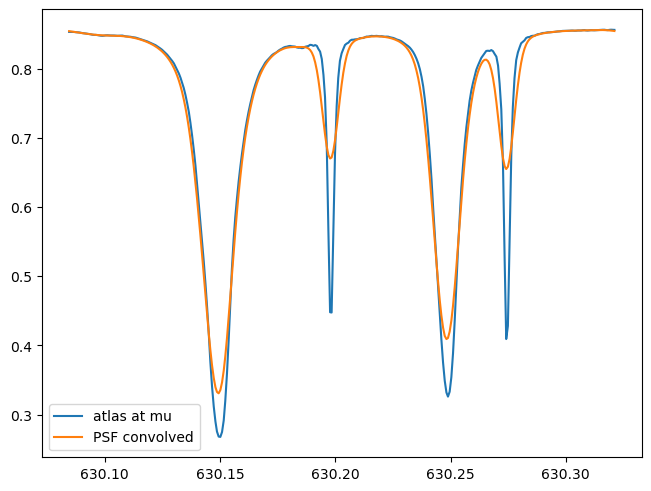

In [14]:
PSF_FWHM_6302   = 0.007
MU_AVG = 0.7

lambda0_630 = 630.200
fts = satlas()
FeI_630_obs = fts.nmsiatlas(wave_clv[0], wave_clv[-1])
norm_atlas  = FeI_630_obs[1] / FeI_630_obs[2]

Natlas, = FeI_630_obs[1].shape
mu_wave_grid = np.zeros((Natlas, 2), dtype="float")
mu_wave_grid[:, 0] = MU_AVG
mu_wave_grid[:, 1] = FeI_630_obs[0]
atlas_at_mu      = norm_atlas * LimbDark(lambda0_630, MU_AVG) * clv_interp(mu_wave_grid)
atlas_at_mu_conv = psf_broad(FeI_630_obs[0], atlas_at_mu, PSF_FWHM_6302, mode="Gaussian")

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
axs.plot(FeI_630_obs[0], atlas_at_mu, label='atlas at mu')
axs.plot(FeI_630_obs[0], atlas_at_mu_conv, label='PSF convolved')

plt.legend()
plt.show()

<Figure size 1400x700 with 0 Axes>

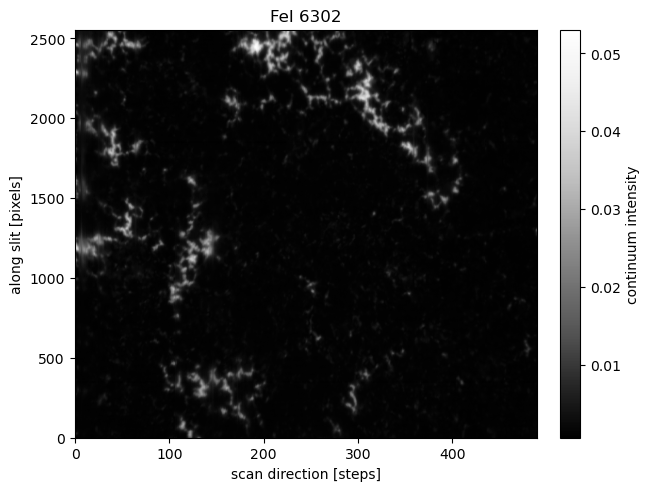

3.917089340628619


In [15]:
POL_TRESHOLD = 0.01
tot_circ_pol = np.sum(np.abs(arm6302_data[:, :, :, 3]) / arm6302_data[:, :, :, 0], axis=2) / Nwave

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

cmap_grey = plt.cm.Greys.reversed()

im = axs.imshow(tot_circ_pol, cmap=cmap_grey, \
                aspect='auto', origin='lower')
axs.set(xlabel = 'scan direction [steps]', ylabel='along slit [pixels]', title='FeI 6302')

plt.colorbar(im, label='continuum intensity')
plt.show()

avg_spectrum = np.mean(arm6302_data[:, :, :, 0], axis=(0, 1))

pol_mask         = ma.getmask(ma.masked_where(tot_circ_pol > POL_TRESHOLD, tot_circ_pol))
avg_spectrum_noB = np.zeros(Nwave)
for la in range(Nwave):
        avg_spectrum_noB[la] = ma.masked_array(arm6302_data[:, :, la, 0], mask=pol_mask).mean()

print(np.count_nonzero(pol_mask) / (Npix*Nscan) * 100)

<Figure size 1400x700 with 0 Axes>

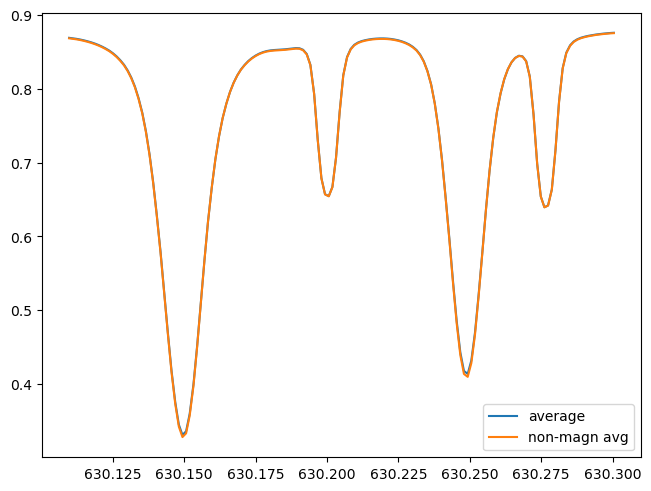

In [16]:
plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
axs.plot(wave6302, avg_spectrum, label='average')
axs.plot(wave6302, avg_spectrum_noB, label='non-magn avg')

plt.legend()
plt.show()

<Figure size 1400x700 with 0 Axes>

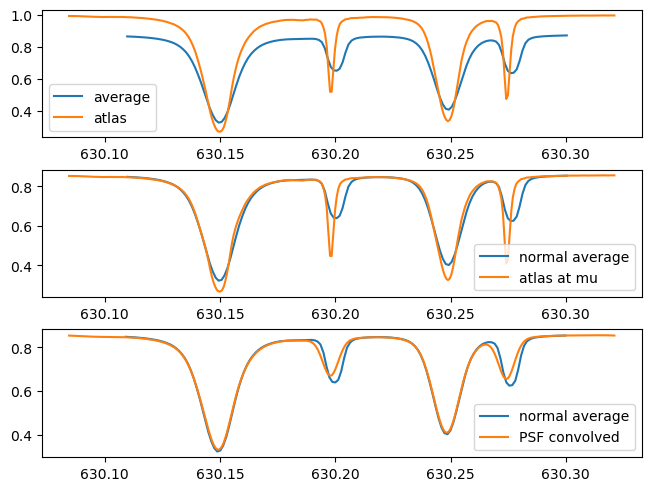

In [17]:
avg_spectrum = np.mean(arm6302_data[500:1500, :, :, 0], axis=(0, 1))

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True)

axs[0].plot(wave6302, avg_spectrum, label="average")
axs[0].plot(FeI_630_obs[0], norm_atlas, label="atlas")
axs[0].legend()

max_index = np.argmax(avg_spectrum)
atlas_index = table_invert(FeI_630_obs[0], wave6302[max_index], mode="index")
arm630_norm = atlas_at_mu[atlas_index] / avg_spectrum[max_index]

axs[1].plot(wave6302, avg_spectrum * arm630_norm, label="normal average")
axs[1].plot(FeI_630_obs[0], atlas_at_mu, label="atlas at mu")
axs[1].legend()

axs[2].plot(wave6302-0.0006, avg_spectrum * arm630_norm, label="normal average")
axs[2].plot(FeI_630_obs[0], atlas_at_mu_conv, label="PSF convolved")
axs[2].legend()

plt.show()

[[2034, 2039]]


[(2032.0, 2041.0)]

<Figure size 1400x700 with 0 Axes>

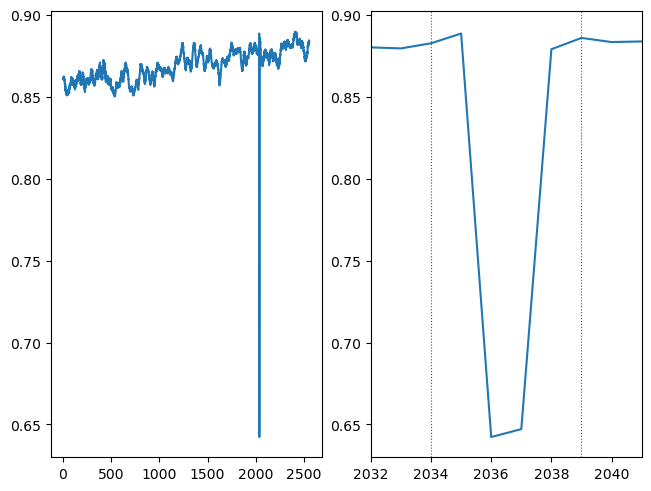

In [18]:
avg_cont_slit = np.mean(arm6302_data[:, :, 0, 0], axis=1)

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

axs[0].plot(avg_cont_slit)

## spurious slit
spurious_pixel = 2000
mask = np.where(avg_cont_slit[spurious_pixel:-1] <= 0.7)
hairline_mask3 = mask[0] + spurious_pixel

HAIR_MARGIN = 2
pairs = [[hairline_mask3[0]-HAIR_MARGIN, hairline_mask3[-1]+HAIR_MARGIN]]
print(pairs)

axs[1].plot(avg_cont_slit)
for index in pairs[0]:
    axs[1].axvline(index, color='m', linestyle=':', linewidth=0.8)
axs[1].set(xlim=[pairs[0][0]-HAIR_MARGIN , pairs[0][1]+HAIR_MARGIN])


[2034, 2039]


<Figure size 1400x700 with 0 Axes>

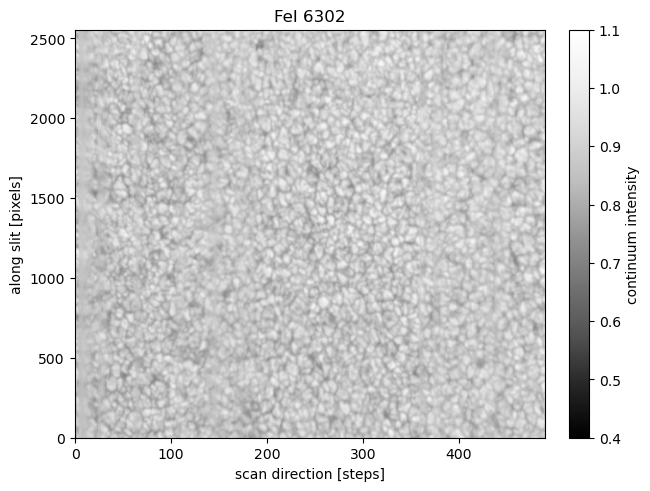

In [20]:
for pair in pairs:
    print(pair)
    for n in range(Nstokes):
        for m in range(Nwave):
            for i in range(Nscan):
                for j in range(pair[0]+1, pair[1]-1, 1):
                    frac = (pair[1] - j) / (pair[1] - pair[0])
                    arm6302_data[j, i, m, n] = (1.0 - frac) * arm6302_data[pair[0], i, m, n] + \
                                               frac * arm6302_data[pair[1], i, m, n]


plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

cmap_grey = plt.cm.Greys.reversed()

im = axs.imshow(arm6302_data[:, :, 0, 0], cmap=cmap_grey, \
                vmin=0.4, vmax=1.1, \
                aspect='auto', origin='lower')
axs.set(xlabel = 'scan direction [steps]', ylabel='along slit [pixels]', title='FeI 6302')

plt.colorbar(im, label='continuum intensity')
plt.show()                   

In [21]:
arm6302_data_clip = arm6302_data[NxCaII_0:NxCaII_1, NyCaII_0:NyCaII_1, :, :]
(Npix, Nscan, Nwave, Nstokes) = np.shape(arm6302_data_clip)
print(Npix, Nscan, Nwave, Nstokes)

tot_circ_pol = np.sum(np.abs(arm6302_data_clip[:, :, :, 3]) / arm6302_data_clip[:, :, :, 0], axis=2) / Nwave
pol_mask     = ma.getmask(ma.masked_where(tot_circ_pol > POL_TRESHOLD, tot_circ_pol))

1668 487 150 4


In [22]:
VISP_SLIT    = 0.2142   ## slit width, in arcsec
VISP_PIX_630 = 0.0298

Npix_slit_avg = (np.floor(VISP_SLIT // VISP_PIX_630)).astype(int)
Npix_rebin = (np.floor(Npix // Npix_slit_avg)).astype(int)
print(Npix, Npix_rebin, Npix_slit_avg)

1668 238 7


<Figure size 1400x700 with 0 Axes>

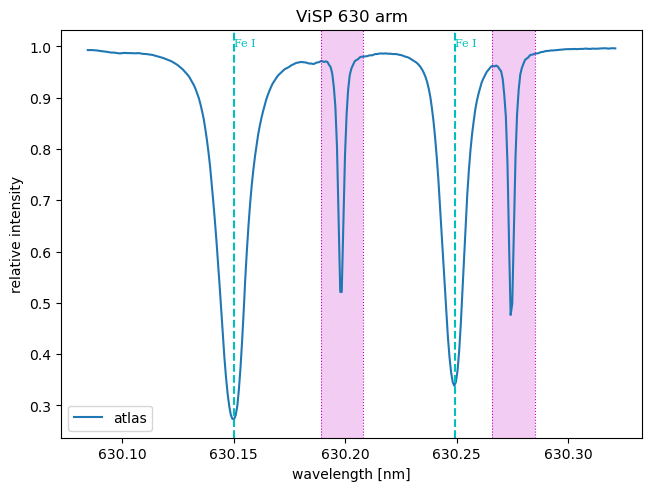

In [23]:
def ViSP_arm_makeup(axs, title, atlas, lines, telluric):
    
    normatlas = atlas[1] / atlas[2]
    axs.plot(atlas[0], normatlas, label='atlas')
    
    axs.set(title=title, xlabel='wavelength [nm]', ylabel='relative intensity')
    trans = mtransforms.blended_transform_factory(axs.transData, axs.transAxes)

    for key,value in lines.items():
        axs.axvline(key, color='c', linestyle='--')
        axs.text(key, 1.0, value, fontfamily='serif', fontsize=8, color='c')
    
    for pair in telluric:
        axs.fill_between (pair, 0, 1, facecolor='m', alpha=0.2, transform=trans)
        for wave in pair:
            axs.axvline(wave, color='m', linestyle=':', linewidth=0.8)

    axs.legend()
    
plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

lines_arm630    = {630.15012: 'Fe I', 630.24936: 'Fe I'}
telluric_arm630 = [[630.189, 630.208], [630.266, 630.285]]

ViSP_arm_makeup(axs, 'ViSP 630 arm', FeI_630_obs, lines_arm630, telluric_arm630)

In [24]:
last_pixel = Npix_slit_avg * Npix_rebin

stokes_630 = np.empty([Nstokes, Nwave, Nscan, Npix_rebin], dtype='float')
stokes_630 = np.transpose(np.mean(np.reshape(arm6302_data_clip[0:last_pixel, :, :, :], \
                                             (Npix_rebin, Npix_slit_avg, Nscan, Nwave, Nstokes)), axis=1), \
                          axes=(3, 2, 1, 0))

mask = np.zeros(Nwave, dtype=np.int8)
for pair in telluric_arm630:
    mask[np.where((wave6302 >= pair[0]) & (wave6302 <= pair[1]))] = -1

for n in range(Nstokes):
    for i in range(Nscan):
        for j in range(Npix_rebin):
            st = stokes_630[n, :, i, j] * arm630_norm
            if n == 0:
                st[np.where(mask == -1)] = -1.0
            else:
                st[np.where(mask == -1)] = 0.0
            
            stokes_630[n, :, i, j] = st

In [25]:
stokes_630.shape

(4, 150, 487, 238)

<Figure size 1400x700 with 0 Axes>

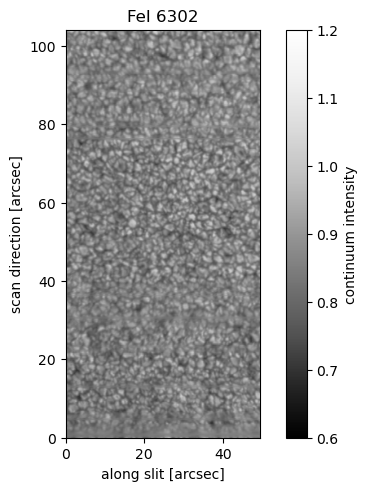

In [26]:
xarcsec = (VISP_PIX_630 * Npix_slit_avg) * np.arange(0, Npix_rebin)
yarcsec = VISP_SLIT * np.arange(0, Nscan)


plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

im = axs.imshow(stokes_630[0, 0, :, :], cmap=cmap_grey, \
                vmin=0.6, vmax=1.2, \
                origin='lower', \
                extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]])
axs.set(xlabel='along slit [arcsec]', ylabel = 'scan direction [arcsec]', title='FeI 6302')

plt.colorbar(im, label='continuum intensity')
plt.show()

In [27]:
fits_dir = scan_dir + 'Inv_Fits/'

hdu  = fits.PrimaryHDU(stokes_630)
hdul = fits.HDUList([hdu])
hdul.writeto(fits_dir + 'FeI_630_1_118_' + scanID + '.fits', overwrite=True)

(Nstokes, Nwave, Nscan, Npix_rebin) = np.shape(stokes_630)

lambda_ref      = 630.15012
lambda_step_mA  = (wave6302[-1] - wave6302[0]) / (Nwave - 1) * NM_TO_ANGSTROM / MILLI
initial_lambda  = (wave6302[0] - lambda_ref) * NM_TO_ANGSTROM / MILLI
final_lambda    = (wave6302[-1] - lambda_ref) * NM_TO_ANGSTROM  / MILLI

print('Initial lambda: {:9.6f}, Step: {:5.6f}, Final lambda: {:9.6f}'.format(initial_lambda, \
                                                                       lambda_step_mA, final_lambda))

Initial lambda: -404.000000, Step: 12.800000, Final lambda: 1503.200000


<Figure size 1400x700 with 0 Axes>

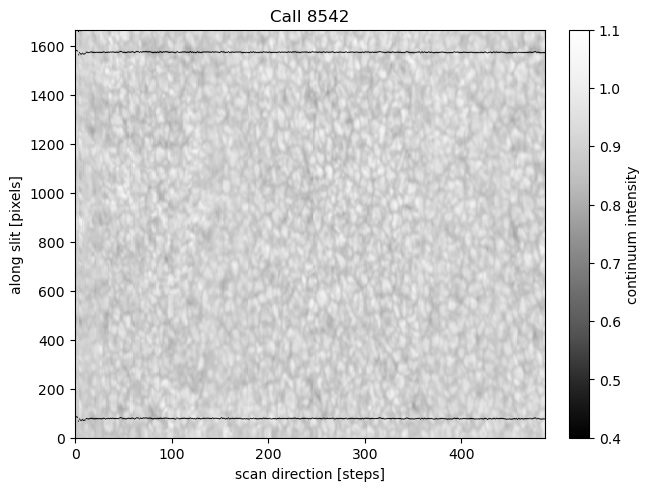

In [28]:
plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

cmap_grey = plt.cm.Greys.reversed()

im = axs.imshow(arm8542_data[NxCaII_0:NxCaII_1, NyCaII_0:NyCaII_1, 0, 0], cmap=cmap_grey, \
                vmin=0.4, vmax=1.1, \
                aspect='auto', origin='lower')
axs.set(xlabel = 'scan direction [steps]', ylabel='along slit [pixels]', title='CaII 8542')

plt.colorbar(im, label='continuum intensity')
plt.show()

In [28]:
arm8542_data_clip = arm8542_data[NxCaII_0:NxCaII_1, NyCaII_0:NyCaII_1, :, :]
(Npix, Nscan, Nwave, Nstokes) = np.shape(arm8542_data_clip)
print(Npix, Nscan, Nwave, Nstokes)

1668 487 500 4


[78 79] [1572 1573]
[[73, 84], [1567, 1578]]


<Figure size 1400x700 with 0 Axes>

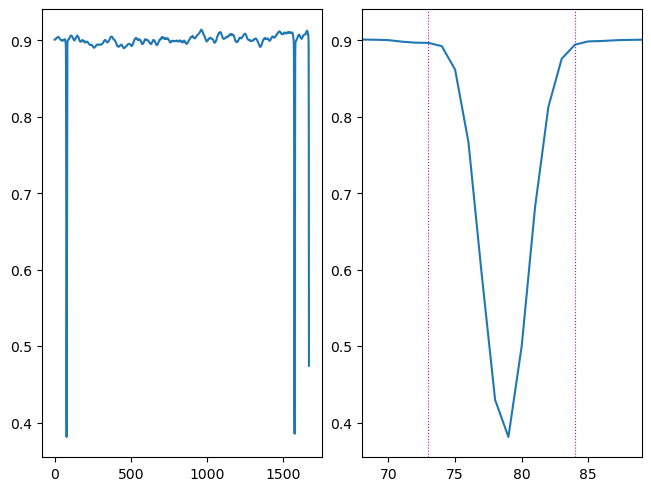

In [29]:
avg_cont_slit = np.mean(arm8542_data_clip[:, :, 0, 0], axis=1)

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

axs[0].plot(avg_cont_slit)

mid_pixel = (np.floor(Npix / 2)).astype(int)
mask = np.where(avg_cont_slit[0:mid_pixel] <= 0.5)
hairline_mask1 = mask[0]
mask = np.where(avg_cont_slit[mid_pixel:-1] <= 0.5) 
hairline_mask2 = mask[0] + mid_pixel

## spurious slit
#spurious_pixel = 2000
#mask = np.where(avg_cont_slit[spurious_pixel:-1] <= 0.7)
#hairline_mask3 = mask[0] + spurious_pixel

HAIR_MARGIN = 5
print(hairline_mask1, hairline_mask2)
pairs = [[hairline_mask1[0]-HAIR_MARGIN, hairline_mask1[-1]+HAIR_MARGIN],\
         [hairline_mask2[0]-HAIR_MARGIN, hairline_mask2[-1]+HAIR_MARGIN]##, \
##         [hairline_mask3[0]-HAIR_MARGIN, hairline_mask3[-1]+HAIR_MARGIN]
        ]
print(pairs)

axs[1].plot(avg_cont_slit)
for index in pairs[0]:
    axs[1].axvline(index, color='m', linestyle=':', linewidth=0.8)
axs[1].set(xlim=[pairs[0][0]-HAIR_MARGIN , pairs[0][1]+HAIR_MARGIN])

plt.show()

[73, 84]
[1567, 1578]


<Figure size 1400x700 with 0 Axes>

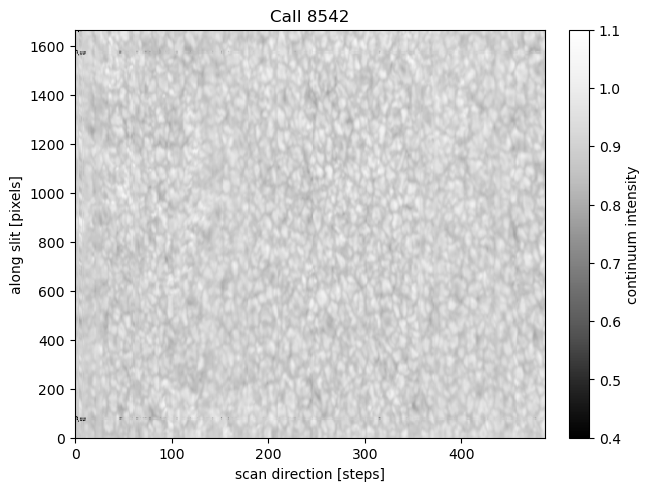

In [30]:
for pair in pairs:
    print(pair)
    for n in range(Nstokes):
        for m in range(Nwave):
            for i in range(Nscan):
                for j in range(pair[0]+1, pair[1]-1, 1):
                    frac = (pair[1] - j) / (pair[1] - pair[0])
                    arm8542_data_clip[j, i, m, n] = (1.0 - frac) * arm8542_data_clip[pair[0], i, m, n] + \
                                            frac * arm8542_data_clip[pair[1], i, m, n]


plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

cmap_grey = plt.cm.Greys.reversed()

im = axs.imshow(arm8542_data_clip[:, :, 0, 0], cmap=cmap_grey, \
                vmin=0.4, vmax=1.1, \
                aspect='auto', origin='lower')
axs.set(xlabel = 'scan direction [steps]', ylabel='along slit [pixels]', title='CaII 8542')

plt.colorbar(im, label='continuum intensity')
plt.show()                   

In [31]:
hdul = fits.open('/home/han/Source/RH/rhf1d/run_CaII_clv/CaII_8542_clv.fits')
hdul.info()

clv_8542 = hdul[0].data
xmu      = hdul[1].data
wave_clv = hdul[2].data
hdul.close()

clv_interp = interpolate.RegularGridInterpolator((xmu, wave_clv), clv_8542)
print(clv_interp([[0.675, 854.0] , [0.675, 855.0]]))

Filename: /home/han/Source/RH/rhf1d/run_CaII_clv/CaII_8542_clv.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (657, 100)   float64   
  1                1 ImageHDU         6   (100,)   float64   
  2                1 ImageHDU         6   (657,)   float64   
[1.03822244 1.00091617]


(2048,) (2048,)


<Figure size 1400x700 with 0 Axes>

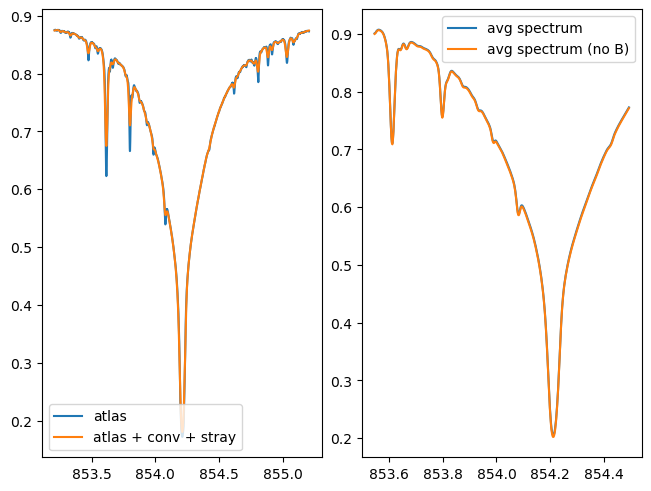

In [32]:
PSF_FWHM_8542 = 0.014     ##0.027
STRAYLIGHT    = 0.00

avg_spectrum = np.mean(arm8542_data_clip[:, :, :, 0], axis=(0, 1))

avg_spectrum_noB = np.zeros(Nwave)
for la in range(Nwave):
    avg_spectrum_noB[la] = ma.masked_array(arm8542_data_clip[:, :, la, 0], mask=pol_mask).mean()

lambda0_8542 = 854.2091
fts = satlas()
CaII_8542_obs = fts.nmsiatlas(lambda0_8542-1.0, lambda0_8542+1.0)
norm_atlas    = CaII_8542_obs[1] / CaII_8542_obs[2]

Natlas, = CaII_8542_obs[1].shape
mu_wave_grid = np.zeros((Natlas, 2), dtype="float")
mu_wave_grid[:, 0] = MU_AVG
mu_wave_grid[:, 1] = CaII_8542_obs[0]

atlas_at_mu      = norm_atlas * LimbDark(lambda0_8542, MU_AVG) * clv_interp(mu_wave_grid)
atlas_at_mu_conv = psf_broad(CaII_8542_obs[0], atlas_at_mu, PSF_FWHM_8542, mode="Gaussian")

beta = atlas_at_mu_conv[0] / (atlas_at_mu_conv[0] + STRAYLIGHT)
atlas_plus_stray = (atlas_at_mu_conv + STRAYLIGHT) * beta

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

axs[0].plot(CaII_8542_obs[0], atlas_at_mu, label='atlas')
axs[0].plot(CaII_8542_obs[0], atlas_plus_stray, label='atlas + conv + stray')
axs[0].legend()

axs[1].plot(wave8542, avg_spectrum, label='avg spectrum')
axs[1].plot(wave8542, avg_spectrum_noB, label='avg spectrum (no B)')
axs[1].legend()

plt.show()

<Figure size 1400x700 with 0 Axes>

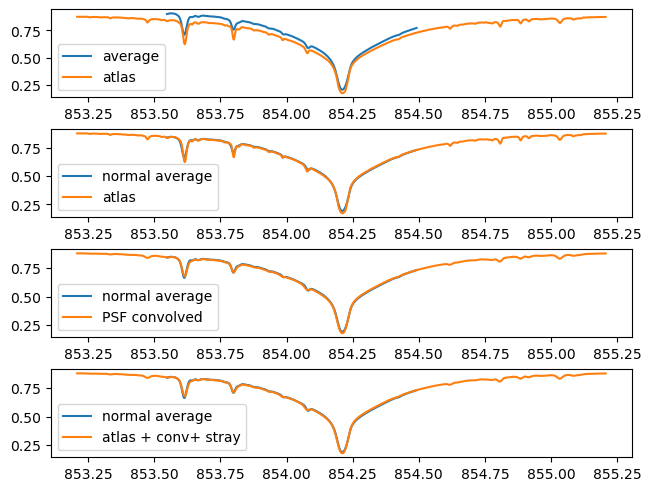

In [33]:
plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True)

axs[0].plot(wave8542, avg_spectrum, label="average")
axs[0].plot(CaII_8542_obs[0], atlas_at_mu, label="atlas")
axs[0].legend()

interp_atlas = interpolate.interp1d(CaII_8542_obs[0], atlas_plus_stray)
norm_cont    = interp_atlas([wave8542[0], wave8542[-1]])
interp_cont  = interpolate.interp1d([wave8542[0], wave8542[-1]], \
                                    norm_cont / [avg_spectrum[0], avg_spectrum[-1]])
arm8542_norm = interp_cont(wave8542)

axs[1].plot(wave8542, avg_spectrum * arm8542_norm, label="normal average")
axs[1].plot(CaII_8542_obs[0], atlas_at_mu, label="atlas")
axs[1].legend()

axs[2].plot(wave8542, avg_spectrum * arm8542_norm, label="normal average")
axs[2].plot(CaII_8542_obs[0], atlas_at_mu_conv, label="PSF convolved")
axs[2].legend()

axs[3].plot(wave8542, avg_spectrum_noB * arm8542_norm, label="normal average")
axs[3].plot(CaII_8542_obs[0], atlas_plus_stray, label="atlas + conv+ stray")
axs[3].legend()



plt.show()

In [34]:
VISP_SLIT     = 0.2142   ## slit width, in arcsec
VISP_PIX_COAL = VISP_PIX_630

Npix_slit_avg = (np.floor(VISP_SLIT // VISP_PIX_COAL)).astype(int)
Npix_rebin = (np.floor(Npix // Npix_slit_avg)).astype(int)
print(Npix_rebin, Npix_slit_avg)

238 7


<Figure size 1400x700 with 0 Axes>

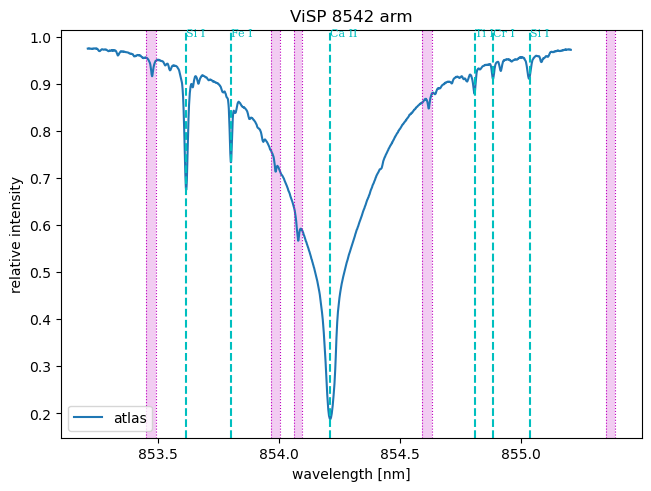

In [35]:
plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

## CaII 8542 arm

telluric_arm8542 = [[853.450, 853.490], [853.965, 854.005], [854.060, 854.095], [854.590, 854.630], \
                    [855.350, 855.390]]
lines_arm8542    = {853.6164: 'Si I', 853.8015: 'Fe I', 854.2091: 'Ca II', \
                    854.8088: 'Ti I', 854.8851: 'Cr I', 855.0353: 'Si I'}

ViSP_arm_makeup(axs, 'ViSP 8542 arm', CaII_8542_obs, lines_arm8542, telluric_arm8542)

plt.show()

In [36]:
last_pixel = Npix_slit_avg * Npix_rebin

stokes_8542 = np.empty([Nstokes, Nwave, Nscan, Npix_rebin], dtype='float')
stokes_8542 = np.transpose(np.mean(np.reshape(arm8542_data_clip[0:last_pixel, :, :, :], \
                                             (Npix_rebin, Npix_slit_avg, Nscan, Nwave, Nstokes)), axis=1), \
                          axes=(3, 2, 1, 0))

mask = np.zeros(Nwave, dtype=np.int8)
for pair in telluric_arm8542:
    mask[np.where((wave8542 >= pair[0]) & (wave8542 <= pair[1]))] = -1

for n in range(Nstokes):
    if n == 0:
        straylight = STRAYLIGHT
    else:
        straylight = 0.0
        
    for i in range(Nscan):
        for j in range(Npix_rebin):
            st = (stokes_8542[n, :, i, j] / beta - straylight) * arm8542_norm
            if n == 0:
                st[np.where(mask == -1)] = -1.0
            else:
                st[np.where(mask == -1)] = 0.0
            
            stokes_8542[n, :, i, j] = st

In [37]:
stokes_8542.shape

(4, 500, 487, 238)

<Figure size 1400x700 with 0 Axes>

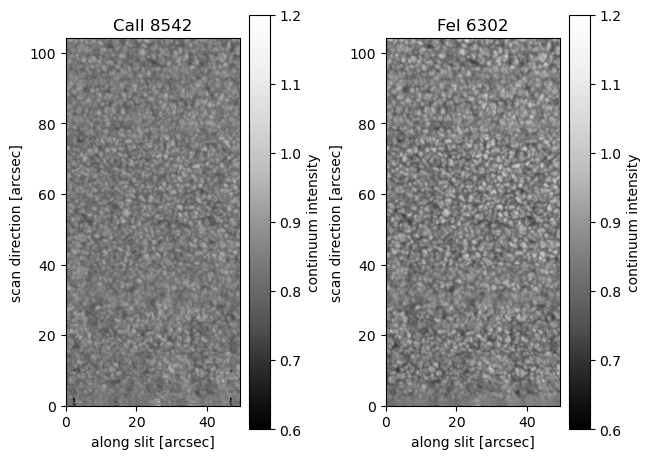

In [38]:
xarcsec = (VISP_PIX_COAL * Npix_slit_avg) * np.arange(0, Npix_rebin)
yarcsec = VISP_SLIT * np.arange(0, Nscan)


plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

im = axs[0].imshow(stokes_8542[0, 0, :, :], cmap=cmap_grey, \
                vmin=0.6, vmax=1.2, \
                origin='lower', \
                extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]])
axs[0].set(xlabel='along slit [arcsec]', ylabel = 'scan direction [arcsec]', title='CaII 8542')

plt.colorbar(im, label='continuum intensity')

im = axs[1].imshow(stokes_630[0, 0, :, :], cmap=cmap_grey, \
                vmin=0.6, vmax=1.2, \
                origin='lower', \
                extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]])
axs[1].set(xlabel='along slit [arcsec]', ylabel = 'scan direction [arcsec]', title='FeI 6302')

plt.colorbar(im, label='continuum intensity')
plt.show()

In [39]:
hdu  = fits.PrimaryHDU(stokes_8542)
hdul = fits.HDUList([hdu])
hdul.writeto(fits_dir + 'CaII_8542_1_118_' + scanID + '.fits', overwrite=True)

(Nstokes, Nwave, Nscan, Npix_rebin) = np.shape(stokes_8542)

lambda_ref      = 854.2091
lambda_step_mA  = (wave8542[-1] - wave8542[0]) / (Nwave - 1) * NM_TO_ANGSTROM / MILLI
initial_lambda  = (wave8542[0] - lambda_ref) * NM_TO_ANGSTROM / MILLI
final_lambda    = (wave8542[-1] - lambda_ref) * NM_TO_ANGSTROM / MILLI

print('Initial lambda: {:9.6f}, Step: {:5.6f}, Final lambda: {:9.6f}'.format(initial_lambda, \
                                                                       lambda_step_mA, final_lambda))

Initial lambda: -6613.500000, Step: 18.911022, Final lambda: 2823.100000


<Figure size 1400x700 with 0 Axes>

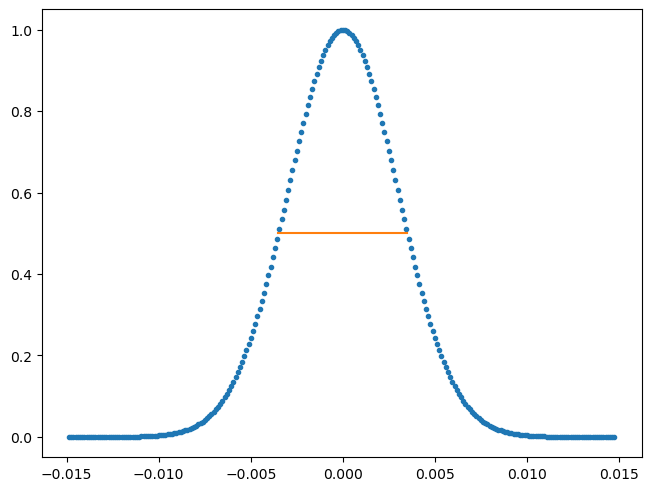

In [40]:
PSF_file_name = fits_dir + 'PSF_FeI6302_CaII8542.per'

ID6302 = 23
ID8542 = 4

psf_format = '    {: 2d}   {:9.8g}' + 4 * '  {:13.5E}' + "\n"

data = []

MAX_SIGMA   = 5.0  ## maximum extent of PSF, in sigma
SAMPL_SIGMA = 25   ##  No of samples per sigma

sigma     = PSF_FWHM_6302 / (2.0 * np.sqrt(2.0 * np.log(2.0)))
PSF_wave  = np.arange(-MAX_SIGMA * sigma, MAX_SIGMA * sigma, sigma/SAMPL_SIGMA, dtype=float)
PSF_value = np.exp(-(PSF_wave / sigma)**2 / 2.0)

plt.figure(figsize=(14, 7))
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

axs.plot(PSF_wave, PSF_value, '.')
axs.plot([-PSF_FWHM_6302/2, PSF_FWHM_6302/2], [0.5, 0.5])

plt.show()


for la in range(len(PSF_wave)):
    data.append(psf_format.format(ID6302, PSF_wave[la] * NM_TO_ANGSTROM / MILLI, PSF_value[la], 0.0, 0.0, 0.0))

sigma     = PSF_FWHM_8542 / (2.0 * np.sqrt(2.0 * np.log(2.0)))
PSF_wave  = np.arange(-MAX_SIGMA * sigma, MAX_SIGMA * sigma, sigma/SAMPL_SIGMA, dtype=float)
PSF_value = np.exp(-(PSF_wave / sigma)**2 / 2.0)

for la in range(len(PSF_wave)):
    data.append(psf_format.format(ID8542, PSF_wave[la] * NM_TO_ANGSTROM / MILLI, PSF_value[la], 0.0, 0.0, 0.0))
    
f = open(PSF_file_name, 'w')
for line in data:
    f.write(line)
    
f.close()

In [41]:
a=np.array([1.0, 2.0, 3.0])
for la in range(len(a)):
    print(a[la])

1.0
2.0
3.0
